# Code for making predictions with and without news features

## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Helper functions
from helper_functions import create_lag_df
from helper_functions import plot_ConfusionMatrix

data_dir = "data/" # Define data path

/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/egor/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
df['district'] = df['district'].str.replace("Center", "").str.replace("South", "").str.replace("North", "").str.replace("East", "").str.replace("West", "").str.strip()
df.set_index(["date", "district"], inplace=True) # Set index
numeric_columns = df.select_dtypes(include=['number'])
df = df.groupby(["date", "district"])[numeric_columns.columns].mean().reset_index()
df.set_index(["date", "district"], inplace=True) # Set index
df = df.round({'ipc': 0})
df

district_code      centx     centy    year  month  ipc  \
date       district                                                            
2007-01-01 Abiemnhom          136.0  29.130190  9.550939  2007.0    1.0  NaN   
           Akobo              114.0  32.853080  7.799214  2007.0    1.0  NaN   
           Anzara              86.0  28.205980  5.309739  2007.0    1.0  NaN   
           Aweil              120.6  27.139798  8.918846  2007.0    1.0  NaN   
           Awerial             99.0  31.229460  6.150162  2007.0    1.0  NaN   
...                             ...        ...       ...     ...    ...  ...   
2020-02-01 Wau                103.0  27.298230  7.284772  2020.0    2.0  3.0   
           Wulu               105.0  29.208890  6.200243  2020.0    2.0  2.0   
           Yambio              82.0  28.547290  5.124909  2020.0    2.0  3.0   
           Yei                 81.0  30.344540  4.252148  2020.0    2.0  3.0   
           Yirol              104.0  30.644715  6.594219  2020.0    2.0  4.0   

                       ha  ndvi_mean  ndvi_anom  rain_mean  ...   et_mean  \
date       district                                         ...             
2007-01-01 Abiemnhom  NaN   0.316412  100.55130   0.025810  ...  0.597288   
           Akobo      NaN   0.361317  114.89340   0.205147  ...  1.113290   
           Anzara     NaN   0.414913   94.84704   0.597445  ...  1.454028   
           Aweil      NaN   0.316901  101.51741   0.026128  ...  1.247115   
           Awerial    NaN   0.389172  106.39390   0.255114  ...  0.510219   
...                   ...        ...        ...        ...  ...       ...   
2020-02-01 Wau        0.0   0.370605  101.23200   0.597954  ...  0.122069   
           Wulu       0.0   0.374735  108.55950   0.665396  ...  0.125452   
           Yambio     0.0   0.468085  103.87600   1.465522  ...  2.018053   
           Yei        0.0   0.452878  105.17720   2.409410  ...  7.450696   
           Yirol      0.0   0.364909  118.40925   0.531674  ...  0.370820   

                       et_anom  count_violence  sum_fatalities  \
date       district                                              
2007-01-01 Abiemnhom  0.162672             0.0             0.0   
           Akobo      0.265087             0.0             0.0   
           Anzara    -1.051144             0.0             0.0   
           Aweil      0.455079             0.0             0.0   
           Awerial   -0.027814             0.0             0.0   
...                        ...             ...             ...   
2020-02-01 Wau       -0.105357             0.0             0.0   
           Wulu      -0.243994             1.0             1.0   
           Yambio     0.066441             0.0             0.0   
           Yei        4.531602             0.0             0.0   
           Yirol     -0.021709             1.5             9.5   

                      food_price_idx       area  cropland_pct         pop  \
date       district                                                         
2007-01-01 Abiemnhom        0.600941   2408.233      1.742261   18973.210   
           Akobo            0.616429   9027.626     10.046920  147537.900   
           Anzara           0.567126   6541.319     18.819290   71208.900   
           Aweil            0.600856   6197.357     14.740720  162124.700   
           Awerial          0.852021   4565.223      4.577788   51774.270   
...                              ...        ...           ...         ...   
2020-02-01 Wau             91.656480  19293.260      0.332958  177331.200   
           Wulu            83.059000  11894.780      0.032678   45158.500   
           Yambio          78.067220   8896.165     19.126490  197278.900   
           Yei             91.476050   6713.251     16.303490  288875.400   
           Yirol          101.200350   5239.805      1.472606   92836.865   

                      ruggedness_mean  pasture_pct  
date       district                                 
2007-01-01 A

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   district_code    10112 non-null  float64
 1   centx            10112 non-null  float64
 2   centy            10112 non-null  float64
 3   year             10112 non-null  float64
 4   month            10112 non-null  float64
 5   ipc              2496 non-null   float64
 6   ha               1792 non-null   float64
 7   ndvi_mean        10112 non-null  float64
 8   ndvi_anom        10112 non-null  float64
 9   rain_mean        10112 non-null  float64
 10  rain_anom        10112 non-null  float64
 11  et_mean          10112 non-null  float64
 12  et_anom          10112 non-null  float64
 13  count_violence   10112 non-null  float64
 14  sum_fatalities   10112 non-null  float64
 15  food_price_idx   101

## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

In [4]:
# ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
# ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
# ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

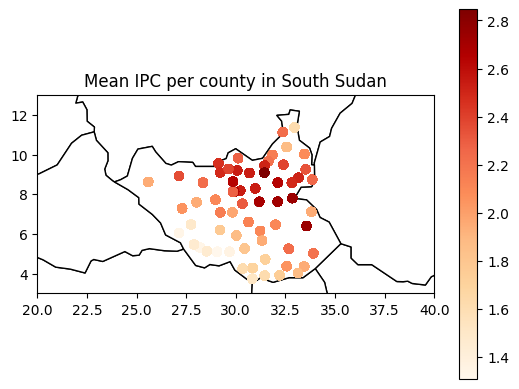

In [5]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [6]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
# df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
# df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns, len(df.columns) # View the newly created columns

(Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
        'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
        'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
        'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
        'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
        'ipc_lag_1'],
       dtype='object'),
 25)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10112 entries, (Timestamp('2007-01-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         10112 non-null  float64
 1   centx                 10112 non-null  float64
 2   centy                 10112 non-null  float64
 3   year                  10112 non-null  float64
 4   month                 10112 non-null  float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             10112 non-null  float64
 8   ndvi_anom             10112 non-null  float64
 9   rain_mean             10112 non-null  float64
 10  rain_anom             10112 non-null  float64
 11  et_mean               10112 non-null  float64
 12  et_anom               10112 non-null  float64
 13  count_violence        10112 non-null 

In [8]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [9]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)

#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)
    
#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [10]:
news_df = pd.read_csv(data_dir + "df_news_districted_original.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_df = news_df.drop(columns=['Unnamed: 0'])
# news_df = news_df.rename(columns = {'districts': 'district'})
# news_df = news_df.rename(columns={"location_article": "district"})

In [11]:
news_df

,date,location_article,hunger,refugees,humanitarian,conflict,district
0,2011-07-01,Juba,False,False,False,False,Juba
1,2011-07-01,Abyei,False,False,False,False,Yei
2,2011-06-01,Southern Kordofan,False,False,False,False,Bor
3,2011-06-01,Southern Kordofan,False,False,False,False,Jur River
4,2011-06-01,Southern Kordofan,False,False,False,False,Aweil
...,...,...,...,...,...,...,...
627110,2023-04-01,North Darfur State,False,False,False,False,Fashoda
627111,2023-04-01,North Darfur State,False,False,False,False,Manyo
627112,2023-04-01,North Darfur State,False,False,False,False,Melut
627113,2023-04-01,North Darfur State,False,False,False,False,Renk


In [12]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date", 'district'])[column].sum()
        col = col.fillna(0)
        col = col.rolling(3).sum()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [13]:
len(news_df.columns[2:-1]) - 4

0

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [14]:
# country wide news features
news_features = create_news_features(news_df.columns[2:-1])

# news_features.plot();
news_features

hunger  refugees  humanitarian  conflict
date       district                                           
2011-06-01 Abiemnhom     NaN       NaN           NaN       NaN
           Akobo         NaN       NaN           NaN       NaN
           Anzara        NaN       NaN           NaN       NaN
           Aweil         NaN       NaN           NaN       NaN
           Awerial       NaN       NaN           NaN       NaN
...                      ...       ...           ...       ...
2023-04-01 Wau           0.0       0.0           0.0       9.0
           Wulu          0.0       0.0           0.0       9.0
           Yambio        0.0       0.0           0.0       9.0
           Yei           0.0       0.0           0.0       9.0
           Yirol         0.0       0.0           0.0       9.0

[9152 rows x 4 columns]

In [15]:
news_features.columns

Index(['hunger', 'refugees', 'humanitarian', 'conflict'], dtype='object')

In [16]:
# # Get the mean share of articles per ipc for the different topics
# combined = (
#     pd.DataFrame(df['ipc'])
#     .join(news_df.groupby(["date", "district"])["hunger"].mean())
#     .join(news_df.groupby(["date", "district"])["refugees"].mean())
#     .join(news_df.groupby(["date", "district"])["Diplomacy"].mean())
#     .join(news_df.groupby(["date", "district"])["Crisis"].mean())
#     .join(news_df.groupby(["date", "district"])["Security"].mean())
#     .join(news_df.groupby(["date", "district"])["Education"].mean())
#     .join(news_df.groupby(["date", "district"])["International"].mean())
#     .join(news_df.groupby(["date", "district"])["Media"].mean())
#     .join(news_df.groupby(["date", "district"])["Leadership"].mean())
# )


# # Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[["hunger", "refugees", "Diplomacy", "Crisis", "Security", "Education",
#                          "International", "Media", "Leadership"]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );

## Predicting using news features

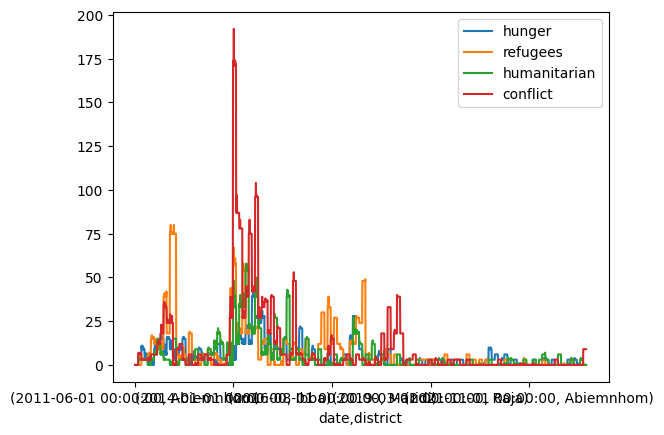

In [17]:
# df.sort_index(level=0, inplace=True)
news_features.plot();

In [18]:
# df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         8192 non-null   float64
 1   centx                 8192 non-null   float64
 2   centy                 8192 non-null   float64
 3   year                  8192 non-null   float64
 4   month                 8192 non-null   float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             8192 non-null   float64
 8   ndvi_anom             8192 non-null   float64
 9   rain_mean             8192 non-null   float64
 10  rain_anom             8192 non-null   float64
 11  et_mean               8192 non-null   float64
 12  et_anom               8192 non-null   float64
 13  count_violence        8192 non-null   

In [20]:
for i in news_features.columns:
    df[i] = df[i].fillna(0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8192 entries, (Timestamp('2009-07-01 00:00:00'), 'Abiemnhom') to (Timestamp('2020-02-01 00:00:00'), 'Yirol')
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_code         8192 non-null   float64
 1   centx                 8192 non-null   float64
 2   centy                 8192 non-null   float64
 3   year                  8192 non-null   float64
 4   month                 8192 non-null   float64
 5   ipc                   2496 non-null   float64
 6   ha                    1792 non-null   float64
 7   ndvi_mean             8192 non-null   float64
 8   ndvi_anom             8192 non-null   float64
 9   rain_mean             8192 non-null   float64
 10  rain_anom             8192 non-null   float64
 11  et_mean               8192 non-null   float64
 12  et_anom               8192 non-null   float64
 13  count_violence        8192 non-null   

In [22]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.metrics import accuracy_score, make_scorer
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model


# # df_prep = df.copy().iloc[:, [7] + list(range(-10, 0))].dropna()


# X = df.iloc[:, -14:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
#     X_test = X_test[X_train.columns]
    
#     #Interpolate training data to generate more training points
#     # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # X_train.reset_index(level=0, drop=True, inplace=True)
#     # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     # y_train.reset_index(level=0, drop=True, inplace=True)
    
#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     results = model.fit() # Get model results on training data

#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
    
#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())
#     r2_values.append(results.rsquared)

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2

We see that the R2 has risen somewhat compared to the baseline.

### Predicting crisis/no crisis

We can also transform the IPC prediction in a binary classification problem by considering IPC 3+ as crisis, and IPC 2- as no-crisis. Let's give a simple example

In [23]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [24]:
# X = df.iloc[:, -10:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits
# acc_values = list() # Initinalize empty lists to score accuracy scores

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits
    
#     y_binary = y > 2 # Convert y to binary variable
#     y_binary[y.isna()] = pd.NA # Conserve NaN values
#     y_binary = y_binary.astype("float32") # Convert y to float

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y_binary.iloc[train_index], y_binary.iloc[val_index]
    
#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)
    
#     cols = ['const', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'] # Select columns to use in model
#     model = sm.Logit(y_train, X_train[cols], missing="drop") # Initialize Logit model
#     results = model.fit() # Get model results on training data
#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test[cols]) # Run model on test data

#     # Convert prediction and validation to boolean
#     y_pred = y_pred.round().astype(bool)
#     y_val = y_val.round().astype(bool)

#     # Drop all rows from prediction and validation where validation is null
#     y_pred = y_pred[list(y_val.isnull()['ipc']==False)]
#     y_val.dropna(inplace=True)

#     acc_values.append(accuracy_score(y_val, y_pred)) # Append accuracy to list

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc'], binary = True) # Plot confusion matrix
    
# print(f"Mean Acc: {np.mean(acc_values):.2f}") # Print Acc
# df.info()

In [25]:
df.columns

Index(['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'hunger', 'refugees', 'humanitarian', 'conflict'],
      dtype='object')

In [26]:
# from sklearn.datasets import make_hastie_10_2
# from sklearn.metrics import accuracy_score, make_scorer, f1_score, classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn import linear_model
# from sklearn.metrics import r2_score
# from sklearn.linear_model import Ridge


# # df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


X = df.iloc[:, -8:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

# cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# # Initinalize empty lists to score scores
# mae_values = list()
# r2_values = list()
# accuracy_values = list()
# f1_values = list()

# for train_index, val_index in cv.split(X): # Loop over the different training-test splits

#     # Define X and y data
#     X_train, X_test = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]

#     # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
#     X_train = X_train.dropna(axis=1, how='all').copy()
#     X_test = X_test[X_train.columns]
    
#     #Interpolate training data to generate more training points
#     X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     X_train.reset_index(level=0, drop=True, inplace=True)
#     y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
#     y_train.reset_index(level=0, drop=True, inplace=True)
    
#     model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
#     # model = linear_model.Ridge(alpha=3)

#     results = model.fit() # Get model results on training data

#     print(results.summary()) # Print model summary

#     y_pred = results.predict(X_test) # Run model on test data
#     # y_pred = y_pred.T[0]

#     # Append results to respective lists
#     mae_values.append((y_pred - y_val['ipc']).abs().mean())

#     cur_r2 = results.rsquared
#     # cur_r2 = r2_score(y_pred=results.predict(X_train),
#     #                   y_true=y_train['ipc'])
#     r2_values.append(cur_r2)

#     plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
#     plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
# print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
# print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
# print(classification_report(results))

In [27]:
y = y[X['ipc_lag_1'].notnull()]
X = X[X['ipc_lag_1'].notnull()]

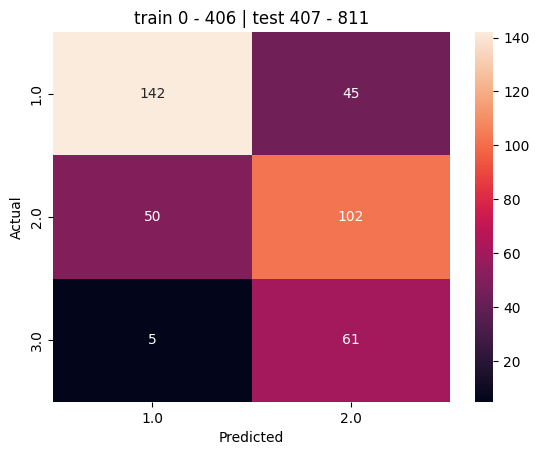

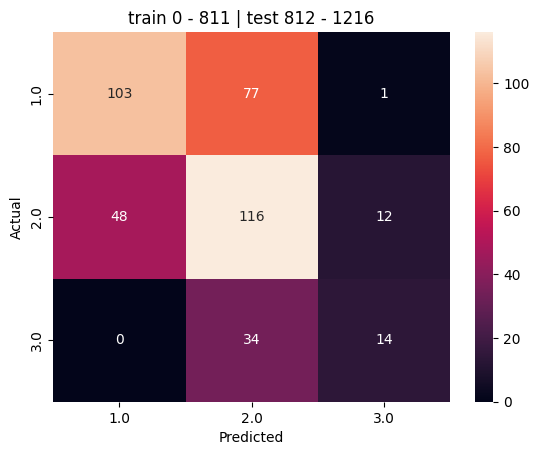

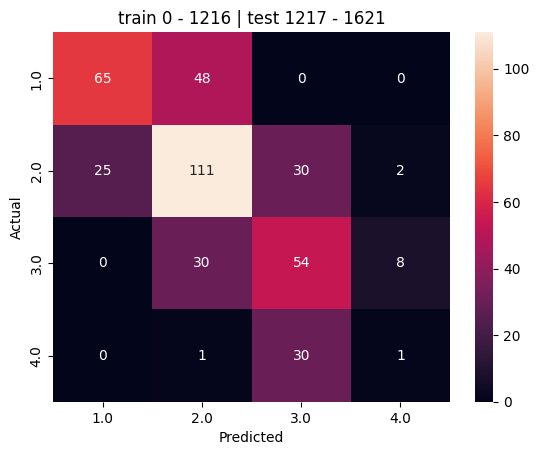

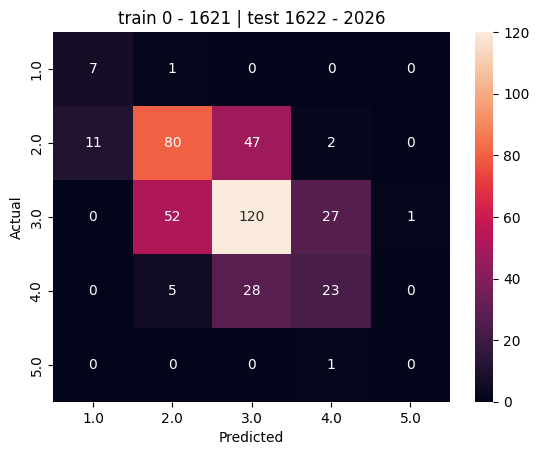

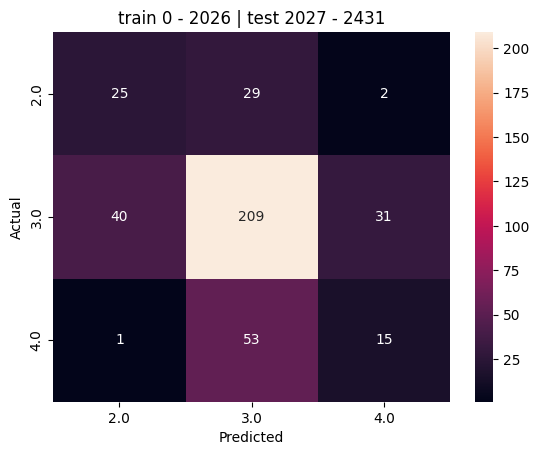

Mean MAE: 0.424
Mean R2: nan
Mean accuracy: 58.62%
Mean weighted f1: 0.572


/home/egor/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/egor/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [28]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression


# df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


# X = df.iloc[:, -28:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
f1_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # X_train.reset_index(level=0, drop=True, inplace=True)
    # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    model = linear_model.Ridge()

    model.fit(X_train, y_train) # Get model results on training data

    # print(results.summary()) # Print model summary

    y_pred = np.round(model.predict(X_test).T[0]) # Run model on test data
    # y_pred = y_pred.T[0]

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    # cur_r2 = results.rsquared
    # cur_r2 = r2_score(y_pred=results.predict(X_train),
    #                   y_true=y_train['ipc'])
    # r2_values.append(cur_r2)

    accuracy_values.append(accuracy_score(y_pred=y_pred,
                      y_true=y_val['ipc']))

    f1_values.append(f1_score(y_pred=y_pred,
                      y_true=y_val['ipc'], average='weighted'))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.3f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.3f}") # Print R2
print(f"Mean accuracy: {100*np.mean(accuracy_values):.2f}%") # Print R2
print(f"Mean weighted f1: {np.mean(f1_values):.3f}") # Print R2

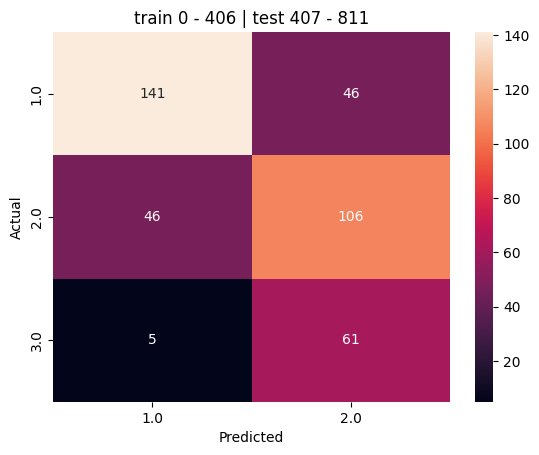

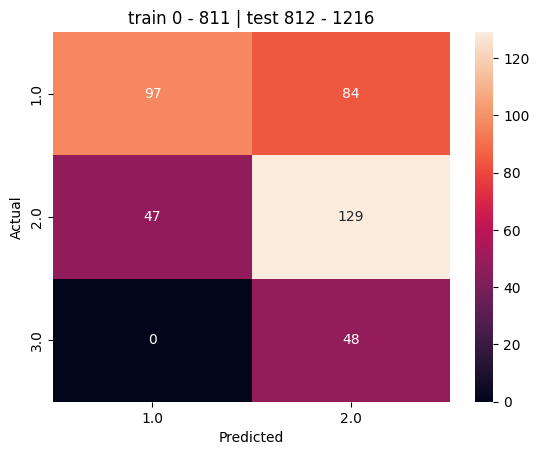

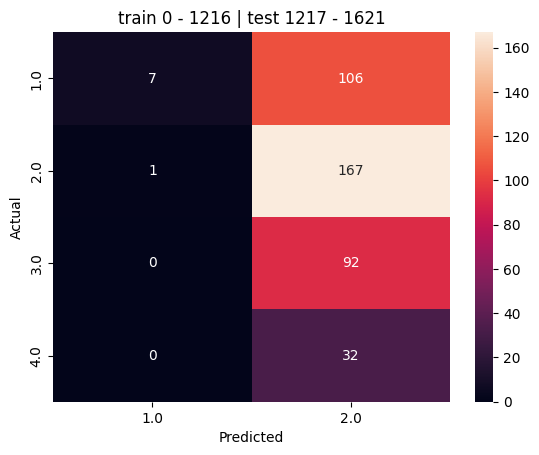

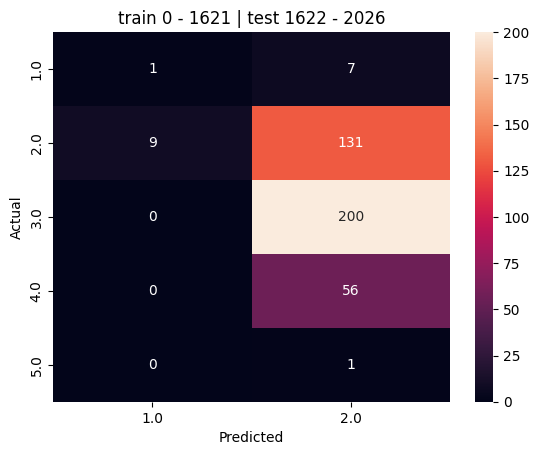

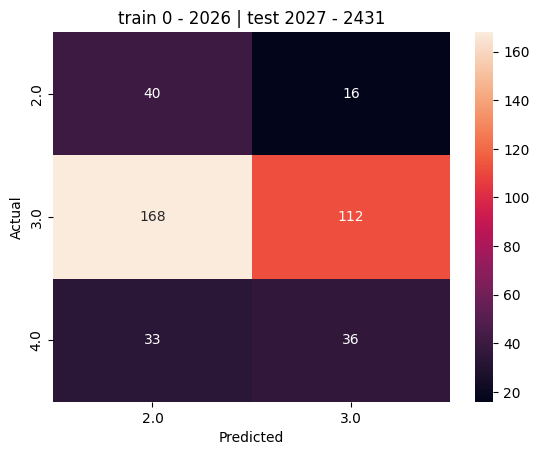

Mean MAE: 0.603
Mean R2: nan
Mean accuracy: 45.98%
Mean weighted f1: 0.384


/home/egor/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/egor/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

In [29]:
from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import r2_score
import xgboost as xgb



# df_prep = df.copy().iloc[:, [5] + list(range(-16, 0))].dropna()


# X = df.iloc[:, -28:] # Define explanatory variables
# X = sm.add_constant(X) # Add constant column of 1s for intercept
# y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
f1_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # X_train.reset_index(level=0, drop=True, inplace=True)
    # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # y_train.reset_index(level=0, drop=True, inplace=True)
    
    # model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data


    # Create a DMatrix for XGBoost (XGBoost uses its own data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Specify the XGBoost parameters (you can adjust these as needed)
    params = {
        "objective": "reg:squarederror",  # Regression task
        "max_depth": 3,  # Maximum depth of the tree
        "eta": 0.01,  # Learning rate
        "subsample": 0.7,  # Fraction of data to randomly sample for each tree
        "colsample_bytree": 0.7,  # Fraction of features to randomly sample for each tree
    }

    # Train the XGBoost model
    num_round = 100  # Number of boosting rounds (you can adjust this)
    model = xgb.train(params, dtrain, num_round)

    # Create a DMatrix for X_test
    dtest = xgb.DMatrix(X_test)

    # Make predictions on the test data
    y_pred = np.round(model.predict(dtest))

    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())

    # cur_r2 = results.rsquared
    # cur_r2 = r2_score(y_pred=results.predict(X_train),
    #                   y_true=y_train['ipc'])
    # r2_values.append(cur_r2)

    accuracy_values.append(accuracy_score(y_pred=y_pred,
                      y_true=y_val['ipc']))

    f1_values.append(f1_score(y_pred=y_pred,
                      y_true=y_val['ipc'], average='weighted'))

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix
    
print(f"Mean MAE: {np.mean(mae_values):.3f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.3f}") # Print R2
print(f"Mean accuracy: {100*np.mean(accuracy_values):.2f}%") # Print R2
print(f"Mean weighted f1: {np.mean(f1_values):.3f}") # Print R2

In [30]:
# # Get the mean share of articles per ipc for the different topics
# combined = (
#     pd.DataFrame(y['ipc'])
#     .join(news_df.groupby(["date"])["hunger"].mean())
#     .join(news_df.groupby(["date"])["refugees"].mean())
#     .join(news_df.groupby(["date"])["conflict"].mean())
#     .join(news_df.groupby(["date"])["humanitarian"].mean())
# )


# # Plot the mean share of articles per ipc value for the different topics
# combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
#     kind="bar", ylabel="Share of total articles"
# );

In [31]:
len(X)

2432

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=69)



# Normalize your data (optional, but recommended)
scaler = StandardScaler()
X_train_model = scaler.fit_transform(X_train.values)
X_test_model = scaler.transform(X_test.values)

# Convert data to PyTorch tensors
X_train_model = torch.FloatTensor(X_train_model)
X_test_model = torch.FloatTensor(X_test_model)
y_train_model = torch.LongTensor(y_train.values)
y_test_model = torch.LongTensor(y_test.values)

# Subtract 1 from the target labels to make them range from 0 to 4
y_train_model = torch.LongTensor([label - 1 for label in y_train_model]).unsqueeze(dim=1)
y_test_model = torch.LongTensor([label - 1 for label in y_test_model]).unsqueeze(dim=1)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_model, y_train_model)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_model, y_test_model)
test_loader = DataLoader(test_dataset, batch_size=64)


In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1945 entries, (Timestamp('2019-02-01 00:00:00'), 'Wulu') to (Timestamp('2016-02-01 00:00:00'), 'Longchuk')
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   const                 1945 non-null   float64
 1   count_violence_lag_3  1945 non-null   float64
 2   ndvi_anom_lag_3       1945 non-null   float64
 3   food_price_idx_lag_3  1945 non-null   float64
 4   ipc_lag_1             1945 non-null   float64
 5   hunger                1945 non-null   float64
 6   refugees              1945 non-null   float64
 7   humanitarian          1945 non-null   float64
 8   conflict              1945 non-null   float64
dtypes: float64(9)
memory usage: 150.4+ KB


In [34]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import plotext
from pathlib import Path
from typing import List


class HungerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HungerModel, self).__init__()
        self.linear_layer_1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear_layer_2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.linear_layer_2(x)
        return x

# Define class weights based on ordinal distance
class_weights = torch.tensor([1.0, 1.0, 2.0, 2.0, 2.0])

input_size = X_train.shape[1]
num_classes = 5

model = HungerModel(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 1200
best_loss = 10000
mean_losses_train: List[torch.Tensor] = []
mean_losses_test: List[torch.Tensor] = []


for epoch in tqdm(range(num_epochs)):
    model.train()
    curr_losses_train: List[torch.Tensor] = []
    curr_losses_test: List[torch.Tensor] = []
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze()
        train_loss = criterion(outputs, labels)
        curr_losses_train.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
    mean_losses_train.append(sum(curr_losses_train) / len(curr_losses_train))

    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            outputs = model(inputs)
            labels = labels.squeeze()
            test_loss = criterion(outputs, labels)
            curr_losses_test.append(test_loss.item())
        mean_losses_test.append(sum(curr_losses_test) / len(curr_losses_test))
    # Print training loss for each epoch
    


    if mean_losses_test[-1] < best_loss:
        best_loss = mean_losses_test[-1]
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {best_loss:.4f}')
        
model = HungerModel(input_size, num_classes)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode
 

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [1/1200] Loss: 1.6185
Epoch [2/1200] Loss: 1.5832
Epoch [3/1200] Loss: 1.5494
Epoch [4/1200] Loss: 1.5178
Epoch [5/1200] Loss: 1.4883
Epoch [6/1200] Loss: 1.4600
Epoch [7/1200] Loss: 1.4335
Epoch [8/1200] Loss: 1.4081
Epoch [9/1200] Loss: 1.3835
Epoch [10/1200] Loss: 1.3604
Epoch [11/1200] Loss: 1.3383
Epoch [12/1200] Loss: 1.3171
Epoch [13/1200] Loss: 1.2968
Epoch [14/1200] Loss: 1.2774
Epoch [15/1200] Loss: 1.2588
Epoch [16/1200] Loss: 1.2411
Epoch [17/1200] Loss: 1.2239
Epoch [18/1200] Loss: 1.2078
Epoch [19/1200] Loss: 1.1923
Epoch [20/1200] Loss: 1.1776
Epoch [21/1200] Loss: 1.1637
Epoch [22/1200] Loss: 1.1503
Epoch [23/1200] Loss: 1.1373
Epoch [24/1200] Loss: 1.1252
Epoch [25/1200] Loss: 1.1137
Epoch [26/1200] Loss: 1.1028
Epoch [27/1200] Loss: 1.0925
Epoch [28/1200] Loss: 1.0824
Epoch [29/1200] Loss: 1.0733
Epoch [30/1200] Loss: 1.0642
Epoch [31/1200] Loss: 1.0553
Epoch [32/1200] Loss: 1.0474
Epoch [33/1200] Loss: 1.0399
Epoch [34/1200] Loss: 1.0325
Epoch [35/1200] Loss: 1

HungerModel(
  (linear_layer_1): Linear(in_features=9, out_features=64, bias=True)
  (relu): ReLU()
  (linear_layer_2): Linear(in_features=64, out_features=5, bias=True)
)

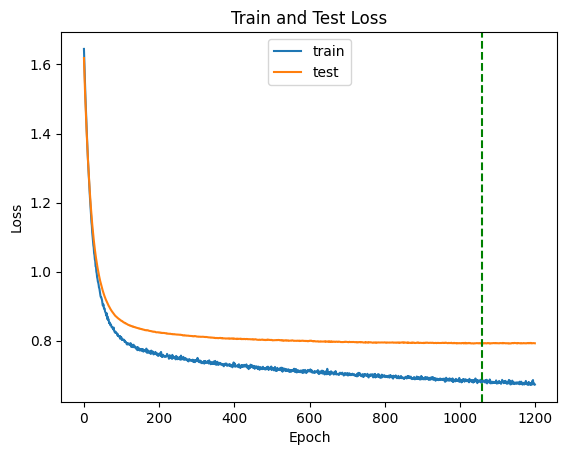

In [35]:
sns.lineplot(x=range(len(mean_losses_train)), y=mean_losses_train, label="train")
sns.lineplot(x=range(len(mean_losses_test)), y=mean_losses_test, label="test")

# Set plot labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss")

# Add a legend
plt.legend()

min_test_loss_epoch = mean_losses_test.index(min(mean_losses_test))
# plt.axvline(x=mean_losses_test.index(min(mean_losses_test)), color='red', linestyle='--', label="Lowest Test Loss")
plt.axvline(x=min_test_loss_epoch, color='green', linestyle='--', label="Lowest Test Loss")
# plt.text(min_test_loss_epoch, mean_losses_test[min_test_loss_epoch], f"Min Epoch: {min_test_loss_epoch}", fontsize=12, ha='right')
# Show the plot
plt.show()

In [36]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, _ = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        # Print predicted classes (1 to 5)
        # print(predicted_classes.numpy())


Confusion Matrix:
[[115  45   1   0]
 [ 32  99  30   0]
 [  1  30  99   3]
 [  0   0  28   4]]
Accuracy: 0.6509240246406571
F1 Score: 0.6407707280953111


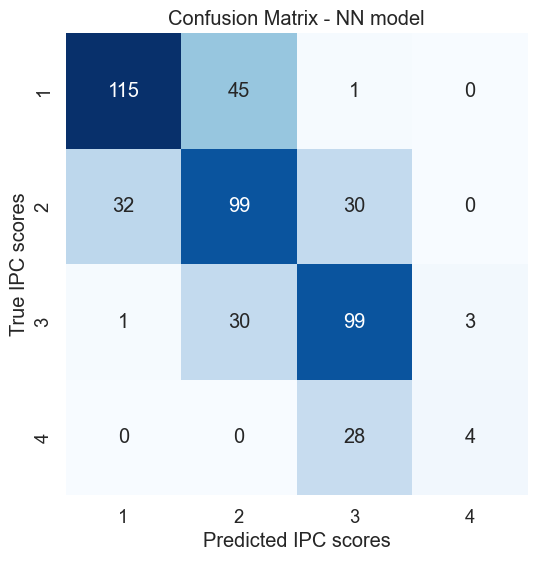

Accuracy: 0.6509240246406571
F1 Score: 0.6407707280953111
Mean Squared Error (MSE): 0.3613963039014374
Mean Absolute Error (MAE): 0.3531827515400411


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probabilities = []  # Added for MSE and MAE

combined_dataset = ConcatDataset([
    TensorDataset(X_train_model, y_train_model),
    TensorDataset(X_test_model, y_test_model)
])

combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        outputs = model(inputs)
        # Apply softmax and get predicted classes using argmax
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted_classes.numpy())

        predicted_probabilities.extend(probabilities.numpy())  # Added for MSE and MAE

# Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
confusion = confusion[:num_classes - 1, :num_classes - 1]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Confusion Matrix:")
print(confusion)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# Calculate MSE and MAE
# Calculate MSE and MAE

# Create a confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=[str(i+1) for i in range(num_classes - 1)],
            yticklabels=[str(i+1) for i in range(num_classes - 1)])
plt.xlabel('Predicted IPC scores')
plt.ylabel('True IPC scores')
plt.title('Confusion Matrix - NN model')
plt.show()


print("Accuracy:", accuracy)
print("F1 Score:", f1)
# ... (remaining code for MSE and MAE)


# Convert true_labels to one-hot encoded format
num_classes = 5  # Assuming you have 5 classes
true_labels_onehot = np.zeros((len(true_labels), num_classes))
true_labels_onehot[np.arange(len(true_labels)), true_labels] = 1

mse = np.mean(np.square(np.array(predicted_labels) - [i[0] for i in true_labels]))
mae = np.mean(np.abs(np.array(predicted_labels) - [i[0] for i in true_labels]))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

In [38]:
for i in test_loader:
    print(i)
    break

[tensor([[ 0.0000e+00,  3.5428e-01,  1.4029e+00, -5.1129e-01,  9.8249e-01,
          5.9437e-02,  6.2387e-02, -1.3524e-01,  1.0019e+00],
        [ 0.0000e+00, -2.2656e-01, -3.2584e-01, -5.9294e-01, -1.2203e+00,
         -6.7534e-01, -1.5112e-01, -5.1281e-01, -2.0640e-01],
        [ 0.0000e+00, -4.5889e-01, -4.8639e-01, -5.3845e-01, -1.1892e-01,
          5.9437e-02, -1.5112e-01, -5.1281e-01, -9.6553e-02],
        [ 0.0000e+00, -4.5889e-01,  2.7260e+00, -1.1766e-01, -1.1892e-01,
         -6.7534e-01,  6.2387e-02, -9.3826e-03, -3.1624e-01],
        [ 0.0000e+00, -4.5889e-01,  4.9122e-01, -5.8165e-01, -1.2203e+00,
         -6.7534e-01, -1.5112e-01, -5.1281e-01, -2.0640e-01],
        [ 0.0000e+00, -4.5889e-01,  1.7165e-01, -5.8069e-01, -1.1892e-01,
         -6.7534e-01, -5.7813e-01, -5.1281e-01, -4.2608e-01],
        [ 0.0000e+00, -2.2656e-01,  1.0751e+00, -5.0125e-01, -1.1892e-01,
          1.8964e+00,  6.2387e-02, -1.3524e-01, -2.0640e-01],
        [ 0.0000e+00, -4.5889e-01, -1.1157e+00,

In [39]:
max(true_labels)

array([3])

<Axes: xlabel='ipc', ylabel='Density'>

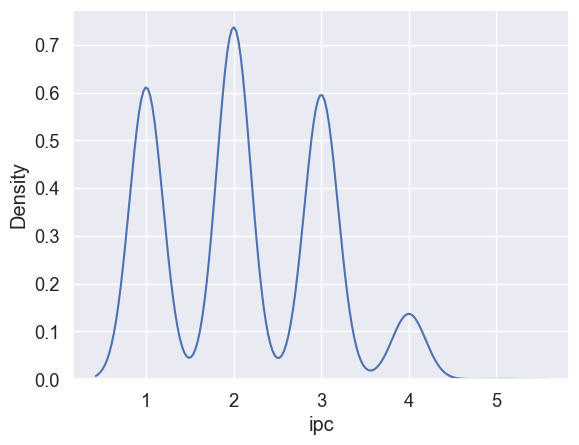

In [40]:
from seaborn import kdeplot, histplot

kdeplot(y[y['ipc'].notnull()]['ipc'])

5.0


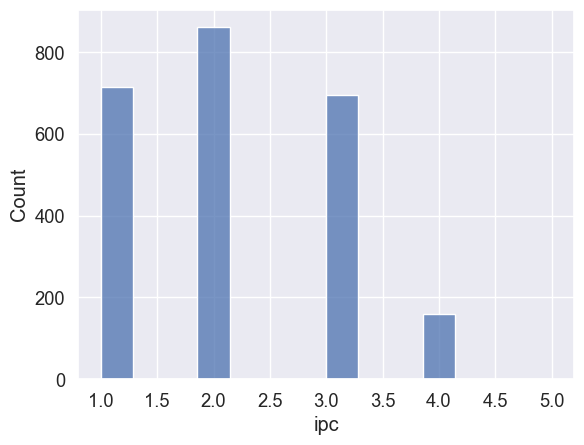

In [41]:
histplot(y['ipc'])
print(y['ipc'].max())

In [42]:
for i in predicted_probabilities[1]:
    print(f"{100*i:.2f}%", end=' ')

84.20% 14.50% 1.30% 0.00% 0.00% 

In [43]:
predict_prob_list = np.ndarray(len(predicted_probabilities))
predict_class_list = np.ndarray(len(predicted_probabilities))

for i in range(len(predicted_probabilities)):
    if i % 10 == 0:
        print()
    predict_prob_list[i] = predicted_probabilities[i].max()
    print(f"{100*predict_prob_list[i]:.2f}%", end=" ")


75.89% 84.20% 67.72% 67.28% 64.10% 54.22% 74.28% 81.72% 85.64% 54.62% 
59.39% 95.80% 74.61% 71.45% 69.25% 59.45% 72.07% 76.17% 57.47% 48.64% 
66.14% 82.01% 87.83% 72.87% 78.39% 63.17% 54.71% 72.91% 70.63% 88.47% 
57.68% 74.89% 91.01% 66.27% 78.84% 52.15% 88.10% 81.21% 73.84% 43.65% 
53.55% 86.66% 59.91% 70.73% 80.09% 66.79% 85.75% 52.65% 65.79% 81.23% 
85.25% 80.32% 61.27% 64.03% 70.20% 74.58% 65.74% 50.74% 60.00% 68.01% 
54.38% 52.96% 66.46% 66.10% 87.62% 79.91% 51.27% 85.10% 73.60% 76.88% 
63.85% 83.27% 76.34% 62.34% 57.51% 81.07% 76.86% 84.11% 63.67% 73.13% 
60.01% 62.79% 50.40% 56.96% 64.56% 61.78% 78.71% 58.24% 58.69% 79.28% 
76.63% 49.31% 83.64% 64.64% 73.75% 73.22% 71.97% 83.21% 42.59% 68.58% 
77.60% 75.78% 78.24% 62.98% 78.42% 59.58% 84.75% 56.77% 67.08% 60.39% 
63.60% 58.61% 57.23% 49.14% 87.39% 74.01% 72.67% 71.52% 83.62% 67.76% 
62.84% 78.50% 84.78% 82.66% 60.42% 71.57% 77.14% 62.08% 62.16% 70.92% 
76.50% 65.43% 71.94% 72.28% 58.11% 76.97% 73.57% 70.54% 85.67% 62.12% 
73.34

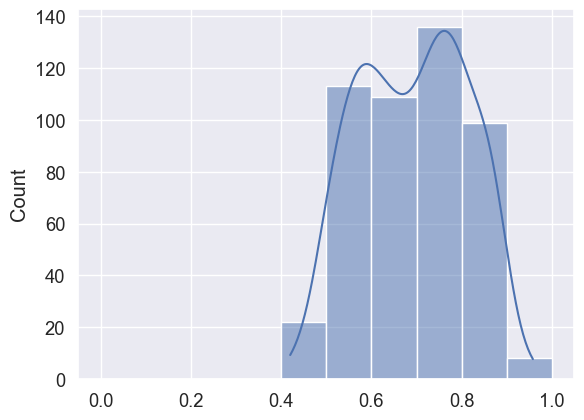

In [44]:
histplot(predict_prob_list, bins=[i/10 for i in range(11)], kde=True);

In [45]:
len(predict_prob_list), len(true_labels), len(predicted_labels)

(487, 487, 487)

In [46]:
# for i in range(len(true_labels)):
#     true_labels[i] = true_labels[i][0]

predicted_labels[0]

2

In [47]:
df_confidence = pd.DataFrame({'true_val': true_labels, 'pred_val': predicted_labels, 'pred_prob': predict_prob_list})
df_confidence = df_confidence[(df_confidence['pred_prob'] > 0) & (df_confidence['pred_prob'] < 1)]
df_confidence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 486
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   true_val   487 non-null    object 
 1   pred_val   487 non-null    int64  
 2   pred_prob  487 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 15.2+ KB


<Axes: xlabel='pred_prob', ylabel='Count'>

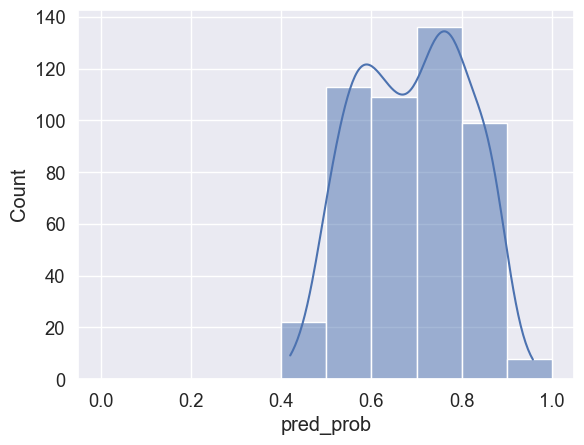

In [48]:
histplot(df_confidence['pred_prob'], bins=[i/10 for i in range(11)], kde=True)

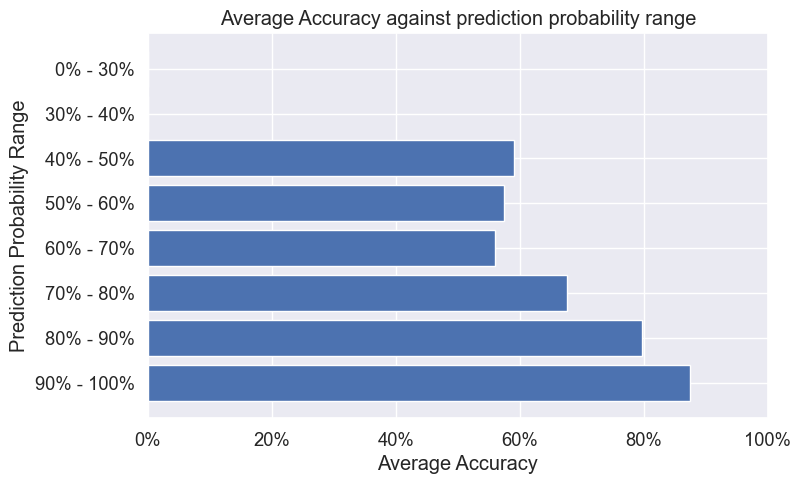

In [49]:
# Define the probability ranges
probability_ranges = [(1.0, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.0)]

# Calculate accuracy for each probability range
accuracies = []
for range_start, range_end in probability_ranges:
    subset = df_confidence[(df_confidence['pred_prob'] >= range_end) & (df_confidence['pred_prob'] <= range_start)]
    if len(subset) > 0:
        accuracy = np.sum(subset['true_val'] == subset['pred_val']) / len(subset)
        accuracies.append(accuracy)
    else:
        accuracies.append(0.0)

# Create the histogram
plt.figure(figsize=(8, 5))
plt.barh([f"{int(range_end*100)}% - {int(range_start*100)}%" for range_start, range_end in probability_ranges], accuracies)
plt.xlabel('Average Accuracy')
plt.ylabel('Prediction Probability Range')
plt.title('Average Accuracy against prediction probability range')
plt.xlim(0, 1)

# Define a function to format the x-axis ticks as percentages
def percentage_formatter(x, pos):
    return f"{int(x * 100)}%"

# Modify the x-axis ticks to display as percentages
x_ticks_percentages = [f"{int(x*100)}%" for x in plt.xticks()[0]]
plt.xticks(plt.xticks()[0], x_ticks_percentages)


plt.show()

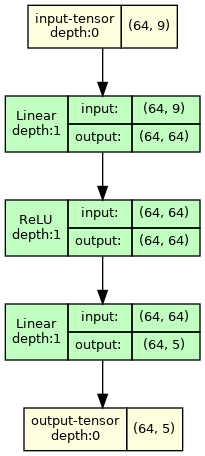

In [50]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

model_graph = draw_graph(HungerModel(input_size, num_classes), input_size=(64, X_train.shape[1]), device='meta', graph_name='RecursiveNet',
    roll=True, expand_nested=True)
model_graph.visual_graph